## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異--> 16, 32的效果最好
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果--> 比較不穩定
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], bn_input=False):
    input_layer = keras.layers.Input(input_shape)
    if bn_input:
        x = keras.layers.BatchNormalization()(input_layer)
    else:
        x = input_layer
    for i, n_units in enumerate(num_neurons):
        if i == 0:
#             x = keras.layers.Dense(units=n_units)(input_layer)
#             x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
#             x = BatchNormalization()(x)
        else:
#             x = keras.layers.Dense(units=n_units)(x)
#             x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
#             x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [16, 32]
MOMENTUM = 0.95

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for bs in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    key_name = 'batchsize_' + str(bs)
    results[key_name]= {
        'train_loss' : model.history.history["loss"]
        ,'valid_loss' : model.history.history["val_loss"]
        ,'train_acc' : model.history.history["acc"]
        ,'valid_acc' : model.history.history["val_acc"]
        }

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 81s 2ms/step - loss: 0.5927 - acc: 0.7876 - val_loss: 1.8219 - val_acc: 0.5143
Epoch 47/50
50000/50000 [==============================] - 80s 2ms/step - loss: 0.5932 - acc: 0.7853 - val_loss: 2.1575 - val_acc: 0.4661
Epoch 48/50
50000/50000 [==============================] - 60s 1ms/step - loss: 0.5880 - acc: 0.7872 - val_loss: 1.9354 - val_acc: 0.4892
Epoch 49/50
50000/50000 [==============================] - 78s 2ms/step - loss: 0.5753 - acc: 0.7914 - val_loss: 1.8894 - val_acc: 0.5036
Epoch 50/50
50000/50000 [==============================] - 93s 2ms/step - loss: 0.5632 - acc: 0.7978 - val_loss: 1.9385 - val_acc: 0.4959


0 batchsize_16
1 batchsize_32


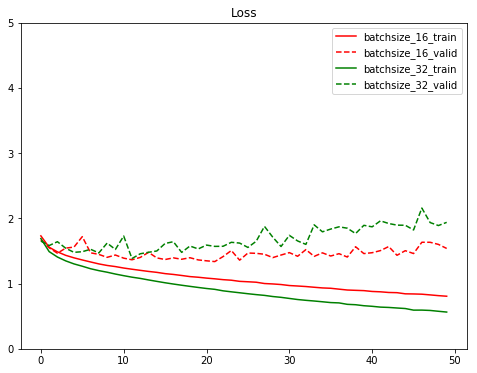

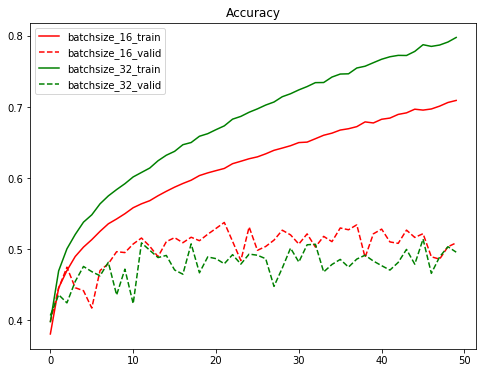

In [10]:
# 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    print(i, cond)
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

0 batchsize_2
1 batchsize_16
2 batchsize_32
3 batchsize_128
4 batchsize_256


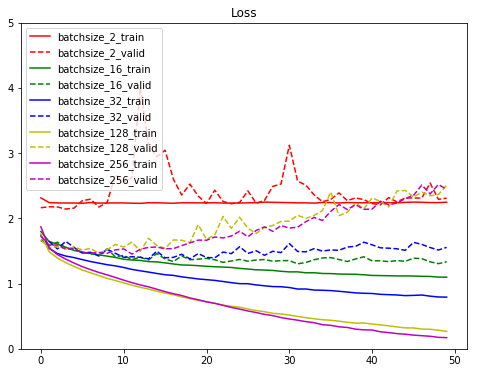

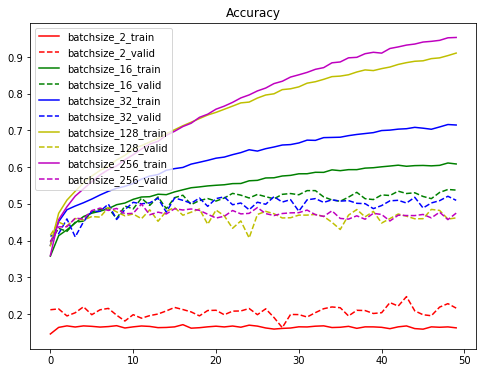

In [10]:
# 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    print(i, cond)
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()